In [1]:
import sys
#!{sys.executable} -m pip install sklearn
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import random
import os
from matplotlib import animation
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import spatial
from IPython.display import HTML
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, ConstantKernel)
from pypointmatcher import pointmatcher as pm, pointmatchersupport as pms
PM = pm.PointMatcher
DP = PM.DataPoints

import importlib
import scripts.theodolite_function as tfu
import scripts.theodolite_utils as tfuu
tfu = importlib.reload(tfu)
from scipy.interpolate import splprep, splev
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from scipy.spatial.transform import Rotation as R
import scripts.gp_prediction_utils as GPf
GPf = importlib.reload(GPf)
import GPy

#1 11 2021
Dist_prism_12 = 1.0398341231585624*1000
Dist_prism_13 = 0.818424700118086*1000
Dist_prism_23 = 0.8806156053859284*1000
Dist_GPS_12 = 0.835637436093363*1000
Dist_GPS_13 = 0.7812173648662254*1000
Dist_GPS_23 = 0.5166745729506486*1000

P1 = np.array([[1,0,0,0.5],[0,1,0,-0.25],[0,0,1,0.3],[0,0,0,1]])
P2 = np.array([[1,0,0,-0.1],[0,1,0,0.4],[0,0,1,0.2],[0,0,0,1]])
P3 = np.array([[1,0,0,-0.7],[0,1,0,0],[0,0,1,0.4],[0,0,0,1]])

# Distance in meter
Dist_prism_12 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P2[0,3],P2[1,3],P2[2,3]])),3)
Dist_prism_13 = round(np.linalg.norm(np.array([P1[0,3],P1[1,3],P1[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
Dist_prism_23 = round(np.linalg.norm(np.array([P2[0,3],P2[1,3],P2[2,3]])-np.array([P3[0,3],P3[1,3],P3[2,3]])),3)
cov_prism = np.array([[0.002,0,0],[0,0.002,0],[0,0,0.002]])
D12_wref = round(np.sqrt(np.linalg.norm(P1-P2)*np.linalg.norm(P1-P2)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
D13_wref = round(np.sqrt(np.linalg.norm(P1-P3)*np.linalg.norm(P1-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
D23_wref = round(np.sqrt(np.linalg.norm(P2-P3)*np.linalg.norm(P2-P3)+(2*cov_prism-2*np.sqrt(np.sqrt(cov_prism)@cov_prism@np.sqrt(cov_prism))).trace()),3)
print(Dist_prism_12,Dist_prism_13,Dist_prism_23)
print(D12_wref,D13_wref,D23_wref)

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


0.89 1.23 0.748
0.89 1.23 0.748


In [2]:
tfuu = importlib.reload(tfuu)
#time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file("./data/simulation/asy_traj_prism_1_3.csv")
#time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file("./data/simulation/asy_traj_prism_2_3.csv")
#time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file("./data/simulation/asy_traj_prism_3_3.csv")

time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file("./data/simulation/sub_traj_prism_1_3.csv")
time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file("./data/simulation/sub_traj_prism_2_3.csv")
time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file("./data/simulation/sub_traj_prism_3_3.csv")

#time_trimble_1, trimble_1 = tfuu.read_point_data_csv_file("./data/total_station/trimble1.csv")
#time_trimble_2, trimble_2 = tfuu.read_point_data_csv_file("./data/total_station/trimble2.csv")
#time_trimble_3, trimble_3 = tfuu.read_point_data_csv_file("./data/total_station/trimble3.csv")

#print(trimble_1)

 /home/norlab/Repo_git/code_publication_IROS2022_MaximeVaidis/scripts/theodolite_utils.py:206: VisibleDeprecationWarning:Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


<IPython.core.display.Javascript object>


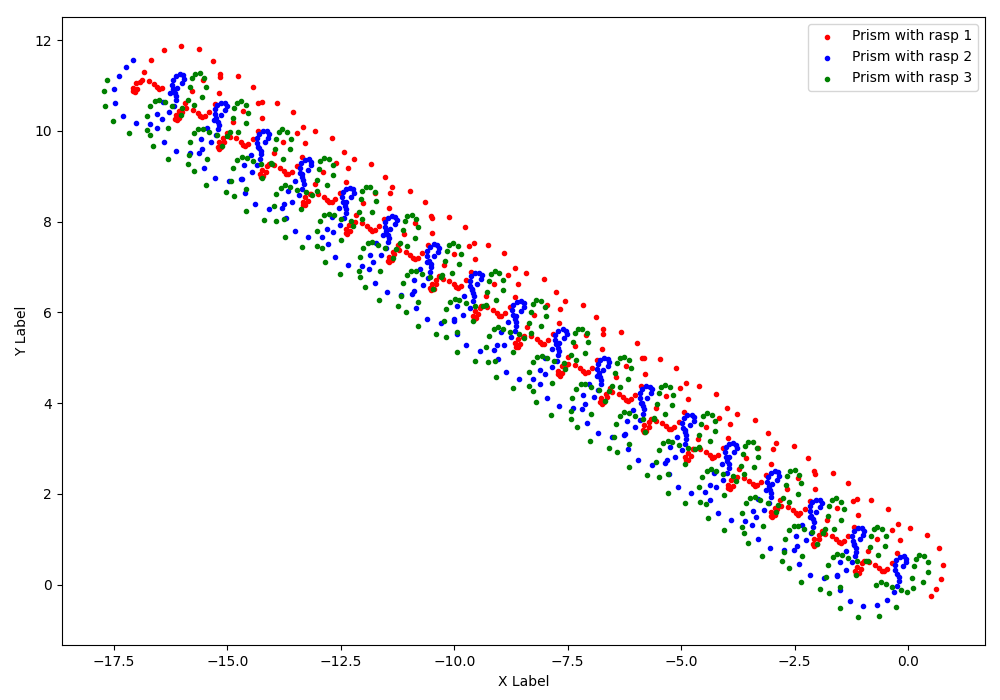

In [3]:
# Test with data
###################################################################################
tfu = importlib.reload(tfu)

# Read markers file of grand axe and show them
#tfu = importlib.reload(tfu)
#file_name = './data/total_station/2021_11_16_theodolite_reference_prisms.txt'
#trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand = tfu.read_marker_file(file_name, 1)
#tfu.plot_trajectories_prism(3, trimble_1, trimble_2, trimble_3, T_1_grand, T_2_grand, T_3_grand, 0, 0,"example.pdf",1)

# Read rosbag of grand axe and show the trajectory
# small loop 1
#file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-15-05-36_filtered.bag"
# small loop 2
#file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-15-13-53_filtered.bag"
# long bag
#file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-15-20-59_filtered.bag"
# short bag end
#file = "/media/norlab/Samsung_disk/Data/IROS_2022/Total_station/2021-11-16-16-15-00_filtered.bag"

#Tf = []
#Tf.append(T_1_grand)
#Tf.append(T_2_grand)
#Tf.append(T_3_grand)
#trajectory_trimble_1, trajectory_trimble_2, trajectory_trimble_3, time_trimble_1, time_trimble_2, time_trimble_3 = tfu.read_rosbag_theodolite_with_tf(file, Tf)
#trimble_1 = np.array(trajectory_trimble_1).T
#trimble_2 = np.array(trajectory_trimble_2).T
#trimble_3 = np.array(trajectory_trimble_3).T

%matplotlib notebook
# Variable to plot in 3d, 0 = 2D, 1 = 3D
plot_3d = 0
# Variable to save file in pdf
save_pdf = 0
# file name to save plot in pdf
file_pdf = "./figs/grand_axe_1.pdf"

tfu.plot_trajectories_prism_alone(3, trimble_1, trimble_2, trimble_3, plot_3d, save_pdf, file_pdf, 1)
            
#Rosbag of imu_node for speed
#tfu = importlib.reload(tfu)
#file = "/home/maxime/theodolites_tests/data_for_processing/ski_trail/2020-10-08-17_58_38_imu_data.bag"
#file = "/home/maxime/theodolites_tests/data_for_processing/ski_trail/2020-10-08-18-01-19_imu_data.bag"
#speed, accel = tfu.read_rosbag_imu_node(file, False, 0)
#print(time_trimble_1[0]-speed[0][0])

Number sub-trajectories: 1


<IPython.core.display.Javascript object>


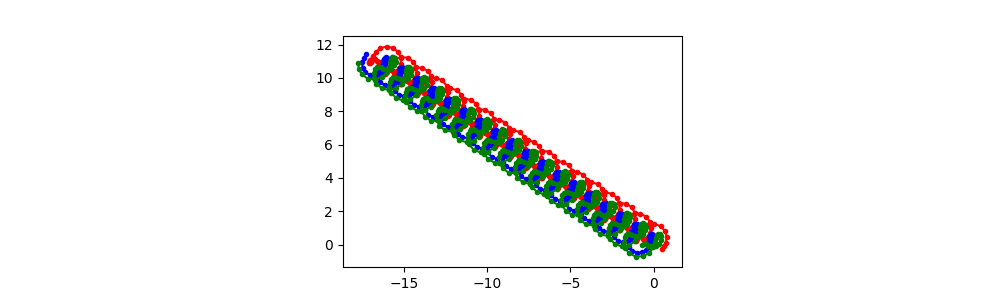

In [4]:
# Work on the data with 3 prisms and 3 theodolites
tfu = importlib.reload(tfu)
# Slipt the data into different interval according to the timestamps of the measurments
limit_time_interval = 4
list_interval, list_time = tfu.split_time_interval_all_data(time_trimble_1, time_trimble_2, time_trimble_3, limit_time_interval)
# Keep only the intervals where the three theodlites have done some measurements at the same time
limit_search = 4
list_trajectories_split = tfu.merge_interval(list_interval, list_time, time_trimble_1, time_trimble_2, time_trimble_3, limit_search)
print("Number sub-trajectories:",len(list_trajectories_split))
# Plot subtrajectory for debug
tfu.plot_subtrajectory_result(0, list_trajectories_split, trimble_1, trimble_2, trimble_3)

In [5]:
number_sub = 0
debut_1 = list_trajectories_split[number_sub][:,0]
debut_2 = list_trajectories_split[number_sub][:,1]
debut_3 = list_trajectories_split[number_sub][:,2]
print(debut_1, debut_2, debut_3)
nombre = 30
debut_1[1]=nombre
debut_2[1]=nombre
debut_3[1]=nombre
time_1 = time_trimble_1[debut_1[0]:debut_1[1]]
time_2 = time_trimble_2[debut_2[0]:debut_2[1]]
time_3 = time_trimble_3[debut_3[0]:debut_3[1]]
traj_1 = trimble_1[0:3,debut_1[0]:debut_1[1]]
traj_2 = trimble_2[0:3,debut_2[0]:debut_2[1]]
traj_3 = trimble_3[0:3,debut_3[0]:debut_3[1]]
print(time_1[0],time_1[-1])
print(time_2[0],time_2[-1])
print(time_3[0],time_3[-1])

[  0 399] [  0 399] [  0 399]
0.0 2.9007251812953236
0.0 2.9007251812953236
0.0 2.9007251812953236


In [11]:
kernel = GPy.kern.RBF(input_dim=1, variance=0.002, lengthscale=1.)

T_1_train_GP = np.atleast_2d(time_1).T
X_1_train_GP = np.atleast_2d(traj_1[0,:]).T
Y_1_train_GP = np.atleast_2d(traj_1[1,:]).T
Z_1_train_GP = np.atleast_2d(traj_1[2,:]).T
T_2_train_GP = np.atleast_2d(time_2).T
X_2_train_GP = np.atleast_2d(traj_2[0,:]).T
Y_2_train_GP = np.atleast_2d(traj_2[1,:]).T
Z_2_train_GP = np.atleast_2d(traj_2[2,:]).T
T_3_train_GP = np.atleast_2d(time_3).T
X_3_train_GP = np.atleast_2d(traj_3[0,:]).T
Y_3_train_GP = np.atleast_2d(traj_3[1,:]).T
Z_3_train_GP = np.atleast_2d(traj_3[2,:]).T

m_x1 = GPy.models.GPRegression(T_1_train_GP,X_1_train_GP,kernel)
m_x1.optimize_restarts(num_restarts = 5, verbose=False)
m_y1 = GPy.models.GPRegression(T_1_train_GP,Y_1_train_GP,kernel)
m_y1.optimize_restarts(num_restarts = 5, verbose=False)
m_z1 = GPy.models.GPRegression(T_1_train_GP,Z_1_train_GP,kernel)
m_z1.optimize_restarts(num_restarts = 5, verbose=False)
m_x2 = GPy.models.GPRegression(T_2_train_GP,X_2_train_GP,kernel)
m_x2.optimize_restarts(num_restarts = 5, verbose=False)
m_y2 = GPy.models.GPRegression(T_2_train_GP,Y_2_train_GP,kernel)
m_y2.optimize_restarts(num_restarts = 5, verbose=False)
m_z2 = GPy.models.GPRegression(T_2_train_GP,Z_2_train_GP,kernel)
m_z2.optimize_restarts(num_restarts = 5, verbose=False)
m_x3 = GPy.models.GPRegression(T_3_train_GP,X_3_train_GP,kernel)
m_x3.optimize_restarts(num_restarts = 5, verbose=False)
m_y3 = GPy.models.GPRegression(T_3_train_GP,Y_3_train_GP,kernel)
m_y3.optimize_restarts(num_restarts = 5, verbose=False)
m_z3 = GPy.models.GPRegression(T_3_train_GP,Z_3_train_GP,kernel)
m_z3.optimize_restarts(num_restarts = 5, verbose=False)


 /home/norlab/.local/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/norlab/.local/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/norlab/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:52: RuntimeWarning:overflow encountered in square
 /home/norlab/.local/lib/python3.6/site-packages/GPy/kern/src/rbf.py:76: RuntimeWarning:invalid value encountered in multiply


In [22]:
x1_pred_GP, sx1_pred_GP = m_x1.predict(np.array([0])[:, None])
print(x1_pred_GP)

[[-0.6618476]]


In [14]:
distance_euclidian_GP=[]
distance_wasserstein_GP=[]
distance_wasserstein_diff_GP=[]
for (i,j,k,l,m,n) in zip(prisme_1_pred_GP,prisme_2_pred_GP,prisme_3_pred_GP,prisme_1_cov_GP,prisme_2_cov_GP,prisme_3_cov_GP):
    ll = np.diag(np.array([i[4], i[5], i[6]]))
    mm = np.diag(np.array([j[4], j[5], j[6]]))
    nn = np.diag(np.array([k[4], k[5], k[6]]))
    d12 = abs(np.linalg.norm(i[1:4]-j[1:4])*1000-Dist_prism_12*1000)
    d13 = abs(np.linalg.norm(i[1:4]-k[1:4])*1000-Dist_prism_13*1000)
    d23 = abs(np.linalg.norm(j[1:4]-k[1:4])*1000-Dist_prism_23*1000)
    md = np.mean([d12, d13, d23])
    distance_euclidian_GP.append(np.array([d12, d13, d23, md]))
    d12_w = np.sqrt(np.linalg.norm(i[1:4]-j[1:4])*np.linalg.norm(i[1:4]-j[1:4])+(l+m-2*np.sqrt(np.sqrt(l)@m@np.sqrt(l))).trace())
    d13_w = np.sqrt(np.linalg.norm(i[1:4]-k[1:4])*np.linalg.norm(i[1:4]-k[1:4])+(l+n-2*np.sqrt(np.sqrt(l)@n@np.sqrt(l))).trace())
    d23_w = np.sqrt(np.linalg.norm(j[1:4]-k[1:4])*np.linalg.norm(j[1:4]-k[1:4])+(m+n-2*np.sqrt(np.sqrt(m)@n@np.sqrt(m))).trace())
    diff_12w = abs(d12_w - D12_wref)*1000
    diff_13w = abs(d13_w - D13_wref)*1000
    diff_23w = abs(d23_w - D23_wref)*1000
    distance_wasserstein_GP.append(np.array([d12_w, d13_w, d23_w]))
    distance_wasserstein_diff_GP.append(np.array([diff_12w, diff_13w, diff_23w]))

NameError: name 'Prediction_1' is not defined

In [6]:
GPf = importlib.reload(GPf)  # long !

T_1_train = np.atleast_2d(time_1).T
X_1_train = traj_1[0,:].ravel()
Y_1_train = traj_1[1,:].ravel()
Z_1_train = traj_1[2,:].ravel()

T_2_train = np.atleast_2d(time_2).T
X_2_train = traj_2[0,:].ravel()
Y_2_train = traj_2[1,:].ravel()
Z_2_train = traj_2[2,:].ravel()

T_3_train = np.atleast_2d(time_3).T
X_3_train = traj_3[0,:].ravel()
Y_3_train = traj_3[1,:].ravel()
Z_3_train = traj_3[2,:].ravel()

kernel = 5
alpha = 0.002**2
n_restarts_optimizer = 9

gp_x_1 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_1_train, X_1_train)  #alpha = variance
gp_y_1 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_1_train, Y_1_train)
gp_z_1 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_1_train, Z_1_train)

gp_x_2 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_2_train, X_2_train)  
gp_y_2 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_2_train, Y_2_train)
gp_z_2 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_2_train, Z_2_train)

gp_x_3 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_3_train, X_3_train)  
gp_y_3 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_3_train, Y_3_train)
gp_z_3 = GPf.GP_training(kernel, alpha, n_restarts_optimizer, T_3_train, Z_3_train)


 /home/norlab/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
 /home/norlab/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
 /home/norlab/.local/lib/python3.6/site-packages/sklearn/gaussian_process/kernels.py:418: ConvergenceWarning:The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.


In [76]:
GPf = importlib.reload(GPf)
begin = min(time_1[0], time_2[0], time_3[0])
end = max(time_1[-1], time_2[-1], time_3[-1])
number_pred = (end-begin+1)*20  #20Hz
#T_prediction = np.atleast_2d(np.linspace(begin, end, number_pred)).T
T_prediction = np.atleast_2d(np.arange(begin, end, 0.05)).T

x1_pred, sx1_pred = GPf.predict_GP(gp_x_1, T_prediction, True)
y1_pred, sy1_pred = GPf.predict_GP(gp_y_1, T_prediction, True)
z1_pred, sz1_pred = GPf.predict_GP(gp_z_1, T_prediction, True)
x2_pred, sx2_pred = GPf.predict_GP(gp_x_2, T_prediction, True)
y2_pred, sy2_pred = GPf.predict_GP(gp_y_2, T_prediction, True)
z2_pred, sz2_pred = GPf.predict_GP(gp_z_2, T_prediction, True)
x3_pred, sx3_pred = GPf.predict_GP(gp_x_3, T_prediction, True)
y3_pred, sy3_pred = GPf.predict_GP(gp_y_3, T_prediction, True)
z3_pred, sz3_pred = GPf.predict_GP(gp_z_3, T_prediction, True)

0.0
11.902975743935984


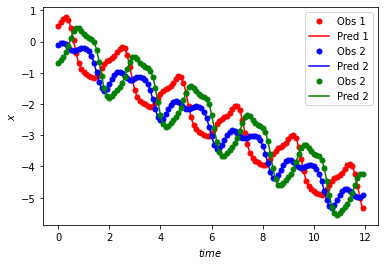

In [77]:
plt.figure(0)
T_train = T_1_train
X_train = X_1_train
x_pred = x2_pred
s_pred = sx2_pred

plt.plot(T_1_train, X_1_train, 'r.', markersize=10, label='Obs 1')
plt.plot(T_prediction, x1_pred, 'r-', label='Pred 1')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x1_pred - 1.9600 * sx1_pred,(x1_pred + 1.9600 * sx1_pred)[::-1]]),
         alpha=.5, fc='r', ec='None')

plt.plot(T_2_train, X_2_train, 'b.', markersize=10, label='Obs 2')
plt.plot(T_prediction, x2_pred, 'b-', label='Pred 2')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x2_pred - 1.9600 * sx2_pred,(x2_pred + 1.9600 * sx2_pred)[::-1]]),
         alpha=.5, fc='b', ec='None')

plt.plot(T_3_train, X_3_train, 'g.', markersize=10, label='Obs 2')
plt.plot(T_prediction, x3_pred, 'g-', label='Pred 2')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x3_pred - 1.9600 * sx3_pred,(x3_pred + 1.9600 * sx3_pred)[::-1]]),
         alpha=.5, fc='g', ec='None')

plt.xlabel('$time$')
plt.ylabel('$x$')
plt.legend(loc='best')
plt.show()

In [78]:
prisme_1_pred = np.array([x1_pred, y1_pred, z1_pred]).T
prisme_2_pred = np.array([x2_pred, y2_pred, z2_pred]).T
prisme_3_pred = np.array([x3_pred, y3_pred, z3_pred]).T
prisme_1_cov_arr = np.array([sx1_pred, sy1_pred, sz1_pred]).T
prisme_2_cov_arr = np.array([sx2_pred, sy2_pred, sz2_pred]).T
prisme_3_cov_arr = np.array([sx3_pred, sy3_pred, sz3_pred]).T

prisme_1_cov_l = []
prisme_2_cov_l = []
prisme_3_cov_l = []
zero_1 = [[0,0,0],[0,0,0],[0,0,0]]
zero_2 = [[0,0,0],[0,0,0],[0,0,0]]
zero_3 = [[0,0,0],[0,0,0],[0,0,0]]

for i,j,k in zip(prisme_1_cov_arr,prisme_2_cov_arr,prisme_3_cov_arr):
    zero_1[0][0]=i[0]
    zero_1[1][1]=i[1]
    zero_1[2][2]=i[2]
    #print(zero_1)
    zero_2[0][0]=j[0]
    zero_2[1][1]=j[1]
    zero_2[2][2]=j[2]
    zero_3[0][0]=k[0]
    zero_3[1][1]=k[1]
    zero_3[2][2]=k[2]
    prisme_1_cov_l.append(zero_1)
    prisme_2_cov_l.append(zero_2)
    prisme_3_cov_l.append(zero_3)
    
prisme_1_cov = np.array(prisme_1_cov_l)
prisme_2_cov = np.array(prisme_2_cov_l)
prisme_3_cov = np.array(prisme_3_cov_l)

distance_euclidian=[]
distance_wasserstein=[]
distance_wasserstein_diff=[]
for (i,j,k,l,m,n) in zip(prisme_1_pred,prisme_2_pred,prisme_3_pred,prisme_1_cov,prisme_2_cov,prisme_3_cov):
    d12 = abs(np.linalg.norm(i-j)*1000-Dist_prism_12*1000)
    d13 = abs(np.linalg.norm(i-k)*1000-Dist_prism_13*1000)
    d23 = abs(np.linalg.norm(j-k)*1000-Dist_prism_23*1000)
    md = np.mean([d12, d13, d23])
    distance_euclidian.append(np.array([d12, d13, d23, md]))
    d12_w = np.sqrt(np.linalg.norm(i-j)*np.linalg.norm(i-j)+(l+m-2*np.sqrt(np.sqrt(l)@m@np.sqrt(l))).trace())
    d13_w = np.sqrt(np.linalg.norm(i-k)*np.linalg.norm(i-k)+(l+n-2*np.sqrt(np.sqrt(l)@n@np.sqrt(l))).trace())
    d23_w = np.sqrt(np.linalg.norm(j-k)*np.linalg.norm(j-k)+(m+n-2*np.sqrt(np.sqrt(m)@n@np.sqrt(m))).trace())
    diff_12w = abs(d12_w - D12_wref)*1000
    diff_13w = abs(d13_w - D13_wref)*1000
    diff_23w = abs(d23_w - D23_wref)*1000
    distance_wasserstein.append(np.array([d12_w, d13_w, d23_w]))
    distance_wasserstein_diff.append(np.array([diff_12w, diff_13w, diff_23w]))

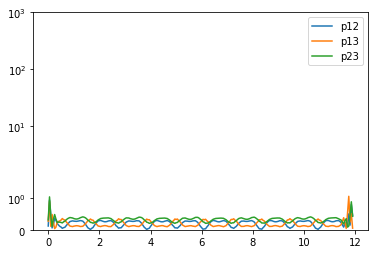

In [79]:
distance_e = np.array(distance_euclidian)
distance_w = np.array(distance_wasserstein_diff)
plt.figure(0)
plt.plot(T_prediction, distance_e[:,0], label="p12")
plt.plot(T_prediction, distance_e[:,1], label="p13")
plt.plot(T_prediction, distance_e[:,2], label="p23")
#plt.plot(distance_w[:,0], label="p12")
#plt.plot(distance_w[:,1], label="p13")
#plt.plot(distance_w[:,2], label="p23")
#plt.plot(distance_r[:,3], label="m")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylim([0, 1000])
plt.show()

239
0.21059214104622373 0.19357546575015266 0.32217638598340215
0.1109331463769836 0.11558057775985599 0.08816698326408189


 /home/norlab/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


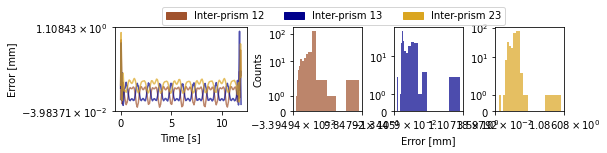

In [80]:
import scripts.theodolite_plot_function as ptfuu
ptfuu = importlib.reload(ptfuu)
name_fig = "./figs/data_traj_2_asy.pdf"
save = False
ptfuu.subplot_prisms_error(T_prediction, distance_e, save, name_fig)

In [ ]:
def confidence_ellipse(M, V, ax, n_std=1.0, facecolor='none', **kwargs):

    cov = V
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = M[0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = M[1]

    transf = matplotlib.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [ ]:
import math
from matplotlib.patches import Ellipse
from scipy.spatial import distance

M1 = np.array([3, -1])         
S1 = np.array([[0.002, 0],[0, 0.002]])
M2 = np.array([0, -1])         
S2 = np.array([[0.03, 0.02],[0.02, 0.1]]) 

print("Euclidien",np.linalg.norm(M1-M2))

#d_mahalanobis = math.sqrt((M-p).T@np.linalg.inv(V)@(M-p))
#d_mahalanobis = distance.mahalanobis(M1, M2, np.linalg.inv(S2))
#print("Mahalanobis",d_mahalanobis)

norm_mean = np.linalg.norm(M1-M2)
sum_cov = S1+S2
root_S1 = np.sqrt(S1)
d_wasserstein = np.sqrt(norm_mean*norm_mean + (sum_cov - 2*np.sqrt(root_S1@S2@root_S1)).trace())
print("Wasserstein",d_wasserstein)

fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(M1[0],M1[1], color="r")
plt.scatter(M2[0],M2[1], color="g")
confidence_ellipse(M1, S1, ax, edgecolor='red')
confidence_ellipse(M2, S2, ax, edgecolor='green')
plt.axis('equal')
plt.show()

In [14]:
# Gpy multiple output

In [111]:
%pylab inline
#!{sys.executable} -m pip install gpy
import pylab as pb
pylab.ion()
import GPy

Populating the interactive namespace from numpy and matplotlib


 /usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:pylab import has clobbered these variables: ['save']
`%matplotlib` prevents importing * from pylab and numpy


In [112]:
number_sub = 0
debut_1 = list_trajectories_split[number_sub][:,0]
debut_2 = list_trajectories_split[number_sub][:,1]
debut_3 = list_trajectories_split[number_sub][:,2]
nombre = 50
debut_1[1]=nombre
debut_2[1]=nombre
debut_3[1]=nombre
time_1 = time_trimble_1[debut_1[0]:debut_1[1]]
time_2 = time_trimble_2[debut_2[0]:debut_2[1]]
time_3 = time_trimble_3[debut_3[0]:debut_3[1]]
traj_1 = trimble_1[0:3,debut_1[0]:debut_1[1]]
traj_2 = trimble_2[0:3,debut_2[0]:debut_2[1]]
traj_3 = trimble_3[0:3,debut_3[0]:debut_3[1]]

T_1_train_MGPO = np.atleast_2d(time_1).T
#X_1_train = traj_1[0,:].ravel()
X_1_train_MGPO = np.atleast_2d(traj_1[0,:]).T
Y_1_train_MGPO = np.atleast_2d(traj_1[1,:]).T
Z_1_train_MGPO = np.atleast_2d(traj_1[2,:]).T
#Y_1_train = traj_1[1,:].ravel()
#Z_1_train = traj_1[2,:].ravel()

T_2_train_MGPO = np.atleast_2d(time_2).T
#X_2_train = traj_2[0,:].ravel()
#Y_2_train = traj_2[1,:].ravel()
#Z_2_train = traj_2[2,:].ravel()
X_2_train_MGPO = np.atleast_2d(traj_2[0,:]).T
Y_2_train_MGPO = np.atleast_2d(traj_2[1,:]).T
Z_2_train_MGPO = np.atleast_2d(traj_2[2,:]).T

T_3_train_MGPO = np.atleast_2d(time_3).T
#X_3_train = traj_3[0,:].ravel()
#Y_3_train = traj_3[1,:].ravel()
#Z_3_train = traj_3[2,:].ravel()
X_3_train_MGPO = np.atleast_2d(traj_3[0,:]).T
Y_3_train_MGPO = np.atleast_2d(traj_3[1,:]).T
Z_3_train_MGPO = np.atleast_2d(traj_3[2,:]).T

T_MGPO = [T_1_train_MGPO, T_1_train_MGPO, T_1_train_MGPO, T_2_train_MGPO, T_2_train_MGPO, T_2_train_MGPO, 
     T_3_train_MGPO, T_3_train_MGPO,
          T_3_train_MGPO]
S_MGPO = [X_1_train_MGPO, Y_1_train_MGPO, Z_1_train_MGPO, X_2_train_MGPO, Y_2_train_MGPO, Z_2_train_MGPO, 
     X_3_train_MGPO, Y_3_train_MGPO, Z_3_train_MGPO]

print(len(T_1_train_MGPO))
#print(X_1_train)

50


In [113]:
begin_time = time.time()
K = GPy.kern.Matern52(1)
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=9,kernel=K)
m = GPy.models.GPCoregionalizedRegression(T_MGPO, S_MGPO, kernel=icm)
m['.*Mat52.var'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
m.optimize()
end_time = time.time()
print(m)
print(end_time-begin_time)


Name : gp
Objective : -1524.1139700719991
Number of Parameters : 29
Number of Optimization Parameters : 28
Updates : True
Parameters:
  gp.                                    |                   value  |  constraints  |  priors
  ICM.Mat52.variance                     |                     1.0  |   +ve fixed   |        
  ICM.Mat52.lengthscale                  |      1.7661143872022318  |      +ve      |        
  ICM.B.W                                |                  (9, 1)  |               |        
  ICM.B.kappa                            |                    (9,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |   2.152138125055203e-43  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |  4.2940165564138804e-40  |      +ve      |        
  mixed_noise.Gaussian_noise_2.variance  |   9.556526133120587e-63  |      +ve      |        
  mixed_noise.Gaussian_noise_3.variance  |   8.258477364769276e-52  |      +ve      |        
  mixed_noise.Gauss

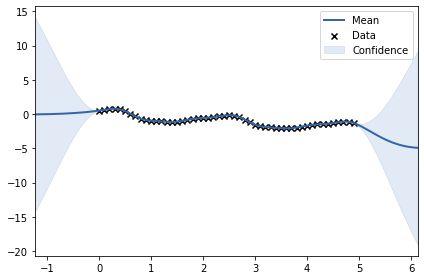

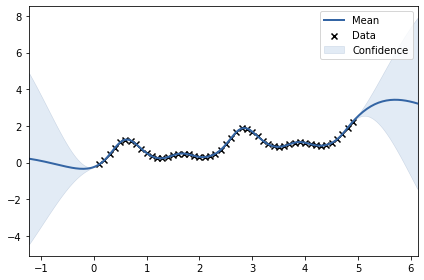

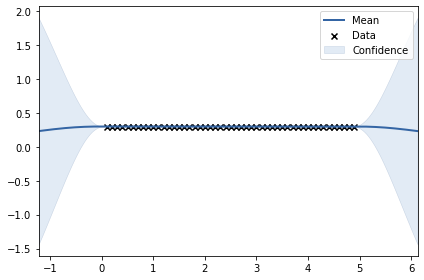

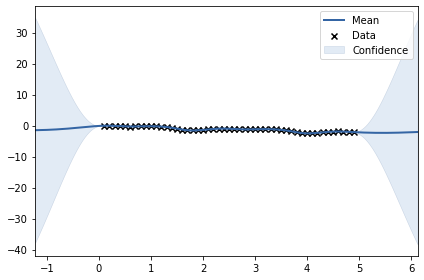

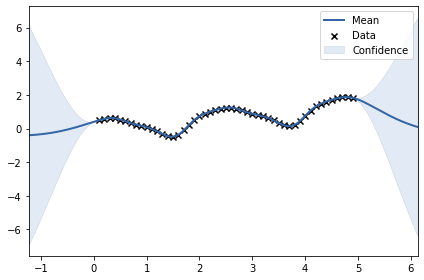

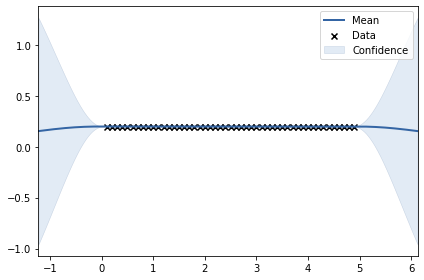

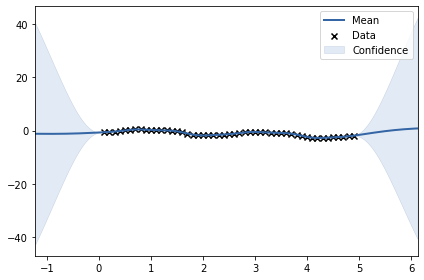

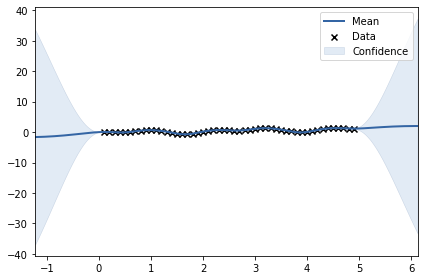

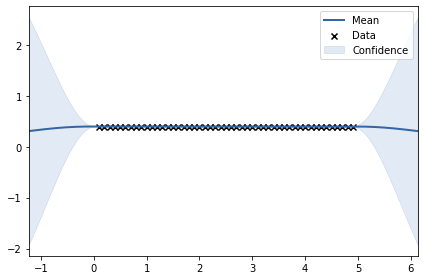

In [114]:
L1 = len(T_1_train_MGPO)
L2 = len(T_2_train_MGPO)
L3 = len(T_3_train_MGPO)
_ = m.plot(fixed_inputs=[(1, 0)], which_data_ycols='all', which_data_rows=slice(0,L1,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 1)], which_data_ycols='all', which_data_rows=slice(L1+1,2*L1,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 2)], which_data_ycols='all', which_data_rows=slice(2*L1+1,3*L1,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 3)], which_data_ycols='all', which_data_rows=slice(3*L1+1,3*L1+L2,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 4)], which_data_ycols='all', which_data_rows=slice(3*L1+1+L2,3*L1+2*L2,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 5)], which_data_ycols='all', which_data_rows=slice(3*L1+1+2*L2,3*L1+3*L2,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 6)], which_data_ycols='all', which_data_rows=slice(3*L1+1+3*L2,3*L1+3*L2+L3,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 7)], which_data_ycols='all', which_data_rows=slice(3*L1+1+3*L2+L3,3*L1+3*L2+2*L3,1), plot_data=True)
_ = m.plot(fixed_inputs=[(1, 8)], which_data_ycols='all', which_data_rows=slice(3*L1+1+3*L2+2*L3,3*L1+3*L2+3*L3,1), plot_data=True)

In [115]:
#print(time_1[0],time_1[-1])
#print(time_2[0],time_2[-1])
#print(time_3[0],time_3[-1])

begin = min(time_1[0], time_2[0], time_3[0])
end = max(time_1[-1], time_2[-1], time_3[-1])
number_pred = (end-begin+1)*20  #20Hz
#T_prediction = np.atleast_2d(np.arange(begin, end, 0.05)).T

#new_Time_MGPO= np.linspace(begin, end, number_pred)[:,None]
new_Time_MGPO= np.arange(begin, end, 0.05)[:,None]
A_MGPO = np.ones_like(new_Time_MGPO)
A_MGPO.fill(0)
new_Time_x1_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(1)
new_Time_y1_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(2)
new_Time_z1_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(3)
new_Time_x2_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(4)
new_Time_y2_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(5)
new_Time_z2_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(6)
new_Time_x3_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(7)
new_Time_y3_MGPO = np.hstack([new_Time_MGPO, A_MGPO])
A_MGPO.fill(8)
new_Time_z3_MGPO = np.hstack([new_Time_MGPO, A_MGPO])

noise_dict = {'output_index':new_Time_x1_MGPO[:,1:].astype(int)}
x1_pred_MGPO, sx1_pred_MGPO = m.predict_noiseless(new_Time_x1_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_y1_MGPO[:,1:].astype(int)}
y1_pred_MGPO, sy1_pred_MGPO = m.predict_noiseless(new_Time_y1_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_z1_MGPO[:,1:].astype(int)}
z1_pred_MGPO, sz1_pred_MGPO = m.predict_noiseless(new_Time_z1_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_x2_MGPO[:,1:].astype(int)}
x2_pred_MGPO, sx2_pred_MGPO = m.predict_noiseless(new_Time_x2_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_y2_MGPO[:,1:].astype(int)}
y2_pred_MGPO, sy2_pred_MGPO = m.predict_noiseless(new_Time_y2_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_z2_MGPO[:,1:].astype(int)}
z2_pred_MGPO, sz2_pred_MGPO = m.predict_noiseless(new_Time_z2_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_x3_MGPO[:,1:].astype(int)}
x3_pred_MGPO, sx3_pred_MGPO = m.predict_noiseless(new_Time_x3_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_y3_MGPO[:,1:].astype(int)}
y3_pred_MGPO, sy3_pred_MGPO = m.predict_noiseless(new_Time_y3_MGPO, Y_metadata=noise_dict)
noise_dict = {'output_index':new_Time_z3_MGPO[:,1:].astype(int)}
z3_pred_MGPO, sz3_pred_MGPO = m.predict_noiseless(new_Time_z3_MGPO, Y_metadata=noise_dict)

In [116]:
x1_pred_MGPO = x1_pred_MGPO.flatten()
x2_pred_MGPO = x2_pred_MGPO.flatten()
x3_pred_MGPO = x3_pred_MGPO.flatten()
y1_pred_MGPO = y1_pred_MGPO.flatten()
y2_pred_MGPO = y2_pred_MGPO.flatten()
y3_pred_MGPO = y3_pred_MGPO.flatten()
z1_pred_MGPO = z1_pred_MGPO.flatten()
z2_pred_MGPO = z2_pred_MGPO.flatten()
z3_pred_MGPO = z3_pred_MGPO.flatten()
sx1_pred_MGPO = sx1_pred_MGPO.flatten()
sx2_pred_MGPO = sx2_pred_MGPO.flatten()
sx3_pred_MGPO = sx3_pred_MGPO.flatten()
sy1_pred_MGPO = sy1_pred_MGPO.flatten()
sy2_pred_MGPO = sy2_pred_MGPO.flatten()
sy3_pred_MGPO = sy3_pred_MGPO.flatten()
sz1_pred_MGPO = sz1_pred_MGPO.flatten()
sz2_pred_MGPO = sz2_pred_MGPO.flatten()
sz3_pred_MGPO = sz3_pred_MGPO.flatten()

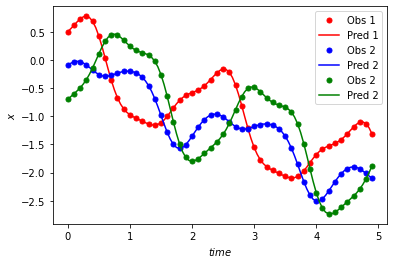

In [117]:
plt.figure(0)
T_train = T_1_train_MGPO
X_train = X_1_train_MGPO
x_pred = x2_pred_MGPO
s_pred = sx2_pred_MGPO
T_prediction = new_Time_MGPO

plt.plot(T_1_train_MGPO, X_1_train_MGPO, 'r.', markersize=10, label='Obs 1')
plt.plot(T_prediction, x1_pred_MGPO, 'r-', label='Pred 1')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x1_pred_MGPO - 1.9600 * sx1_pred_MGPO,(x1_pred_MGPO + 1.9600 * sx1_pred_MGPO)[::-1]]),
         alpha=.5, fc='r', ec='None')

plt.plot(T_2_train_MGPO, X_2_train_MGPO, 'b.', markersize=10, label='Obs 2')
plt.plot(T_prediction, x2_pred_MGPO, 'b-', label='Pred 2')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x2_pred_MGPO - 1.9600 * sx2_pred_MGPO,(x2_pred_MGPO + 1.9600 * sx2_pred_MGPO)[::-1]]),
         alpha=.5, fc='b', ec='None')

plt.plot(T_3_train_MGPO, X_3_train_MGPO, 'g.', markersize=10, label='Obs 2')
plt.plot(T_prediction, x3_pred_MGPO, 'g-', label='Pred 2')
plt.fill(np.concatenate([T_prediction, T_prediction[::-1]]),np.concatenate([x3_pred_MGPO - 1.9600 * sx3_pred_MGPO,(x3_pred_MGPO + 1.9600 * sx3_pred_MGPO)[::-1]]),
         alpha=.5, fc='g', ec='None')

plt.xlabel('$time$')
plt.ylabel('$x$')
plt.legend(loc='best')
plt.show()

In [118]:
prisme_1_pred_MGPO = np.array([x1_pred_MGPO, y1_pred_MGPO, z1_pred_MGPO]).T
prisme_2_pred_MGPO = np.array([x2_pred_MGPO, y2_pred_MGPO, z2_pred_MGPO]).T
prisme_3_pred_MGPO = np.array([x3_pred_MGPO, y3_pred_MGPO, z3_pred_MGPO]).T
prisme_1_cov_arr_MGPO = np.array([sx1_pred_MGPO, sy1_pred_MGPO, sz1_pred_MGPO]).T
prisme_2_cov_arr_MGPO = np.array([sx2_pred_MGPO, sy2_pred_MGPO, sz2_pred_MGPO]).T
prisme_3_cov_arr_MGPO = np.array([sx3_pred_MGPO, sy3_pred_MGPO, sz3_pred_MGPO]).T

prisme_1_cov_l_MGPO = []
prisme_2_cov_l_MGPO = []
prisme_3_cov_l_MGPO = []
zero_1_MGPO = [[0,0,0],[0,0,0],[0,0,0]]
zero_2_MGPO = [[0,0,0],[0,0,0],[0,0,0]]
zero_3_MGPO = [[0,0,0],[0,0,0],[0,0,0]]

for i,j,k in zip(prisme_1_cov_arr_MGPO,prisme_2_cov_arr_MGPO,prisme_3_cov_arr_MGPO):
    zero_1_MGPO[0][0]=i[0]
    zero_1_MGPO[1][1]=i[1]
    zero_1_MGPO[2][2]=i[2]
    #print(zero_1)
    zero_2_MGPO[0][0]=j[0]
    zero_2_MGPO[1][1]=j[1]
    zero_2_MGPO[2][2]=j[2]
    zero_3_MGPO[0][0]=k[0]
    zero_3_MGPO[1][1]=k[1]
    zero_3_MGPO[2][2]=k[2]
    prisme_1_cov_l_MGPO.append(zero_1_MGPO)
    prisme_2_cov_l_MGPO.append(zero_2_MGPO)
    prisme_3_cov_l_MGPO.append(zero_3_MGPO)
    
prisme_1_cov_MGPO = np.array(prisme_1_cov_l_MGPO)
prisme_2_cov_MGPO = np.array(prisme_2_cov_l_MGPO)
prisme_3_cov_MGPO = np.array(prisme_3_cov_l_MGPO)

distance_euclidian_MGPO=[]
distance_wasserstein_MGPO=[]
distance_wasserstein_diff_MGPO=[]
for (i,j,k,l,m,n) in zip(prisme_1_pred_MGPO,prisme_2_pred_MGPO,prisme_3_pred_MGPO,prisme_1_cov_MGPO,prisme_2_cov_MGPO,prisme_3_cov_MGPO):
    d12 = abs(np.linalg.norm(i-j)*1000-Dist_prism_12*1000)
    d13 = abs(np.linalg.norm(i-k)*1000-Dist_prism_13*1000)
    d23 = abs(np.linalg.norm(j-k)*1000-Dist_prism_23*1000)
    md = np.mean([d12, d13, d23])
    distance_euclidian_MGPO.append(np.array([d12, d13, d23, md]))
    d12_w = np.sqrt(np.linalg.norm(i-j)*np.linalg.norm(i-j)+(l+m-2*np.sqrt(np.sqrt(l)@m@np.sqrt(l))).trace())
    d13_w = np.sqrt(np.linalg.norm(i-k)*np.linalg.norm(i-k)+(l+n-2*np.sqrt(np.sqrt(l)@n@np.sqrt(l))).trace())
    d23_w = np.sqrt(np.linalg.norm(j-k)*np.linalg.norm(j-k)+(m+n-2*np.sqrt(np.sqrt(m)@n@np.sqrt(m))).trace())
    diff_12w = abs(d12_w - D12_wref)*1000
    diff_13w = abs(d13_w - D13_wref)*1000
    diff_23w = abs(d23_w - D23_wref)*1000
    distance_wasserstein_MGPO.append(np.array([d12_w, d13_w, d23_w]))
    distance_wasserstein_diff_MGPO.append(np.array([diff_12w, diff_13w, diff_23w]))

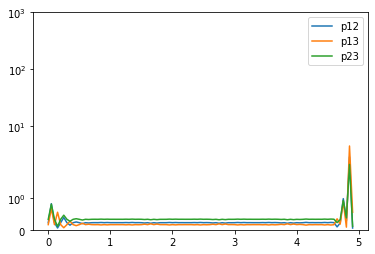

In [119]:
distance_e_MGPO = np.array(distance_euclidian_MGPO)
distance_w_MGPO = np.array(distance_wasserstein_diff_MGPO)
plt.figure(0)
plt.plot(T_prediction, distance_e_MGPO[:,0], label="p12")
plt.plot(T_prediction, distance_e_MGPO[:,1], label="p13")
plt.plot(T_prediction, distance_e_MGPO[:,2], label="p23")
#plt.plot(distance_w_MGPO[:,0], label="w12")
#plt.plot(distance_w_MGPO[:,1], label="w13")
#plt.plot(distance_w_MGPO[:,2], label="w23")
#plt.plot(distance_r[:,3], label="m")
ax = plt.gca()
ax.set_yscale('symlog')
plt.legend(loc='best')
ax.set_ylim([0, 1000])
plt.show()

99
0.261976718871711 0.2292175095536444 0.35604413993846695
0.2888627633974695 0.4497664400893799 0.20152251163720486


 /home/norlab/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning:`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


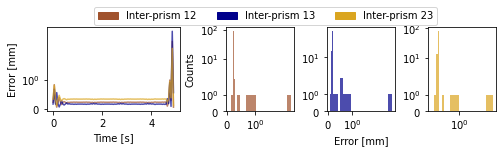

In [120]:
import scripts.theodolite_plot_function as ptfuu
ptfuu = importlib.reload(ptfuu)
name_fig = "./figs/data_traj_2_asy.pdf"
save = False
ptfuu.subplot_prisms_error(T_prediction, distance_e_MGPO, save, name_fig)